In [38]:
train_labels = read.csv(file = '/Users/shreya/Desktop/STAT 503/train_labels.csv')
test_labels = read.csv(file = '/Users/shreya/Desktop/STAT 503/test_labels.csv')
train_x=read.csv(file = '/Users/shreya/Desktop/STAT 503/train_x.csv')
test_x=read.csv(file = '/Users/shreya/Desktop/STAT 503/test_x.csv')

In [39]:
train_labels=as.matrix(train_labels)
test_labels=as.matrix(test_labels)
train_x=as.matrix(train_x)
test_x=as.matrix(test_x)

## SIMPLE MLP - Not SMOTE

In [41]:
library(reticulate)
library(tidyverse)

# Seeing your enviroments
conda_list()

name,python
<chr>,<chr>
base,/Users/shreya/opt/anaconda3/bin/python
STAT507,/Users/shreya/opt/anaconda3/envs/STAT507/bin/python


In [42]:
install.packages('devtools')
devtools::install_github("rstudio/keras")
devtools::install_github("rstudio/tensorflow")
library(devtools)
library(tensorflow)
install_tensorflow(version = "2.8.0")
library(keras)
install_keras()

reticulate::use_condaenv("base", required = TRUE)


The downloaded binary packages are in
	/var/folders/0c/y78gmd852fg62dh0g5d1w9hr0000gn/T//Rtmp9pHLnO/downloaded_packages


Skipping install of 'keras' from a github remote, the SHA1 (0cc377ff) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'tensorflow' from a github remote, the SHA1 (6e3e00e4) has not changed since last install.
  Use `force = TRUE` to force installation




Installation complete.


Installation complete.



In [9]:
set.seed(0) 
model_HCV<- keras_model_sequential()
model_HCV %>%
  layer_dense(units = 100, activation = 'relu') %>%
  layer_dense(units = 200, activation = 'relu') %>%
  layer_dropout(0.25) %>%
  layer_dense(units = 4, activation = 'softmax')

Loaded Tensorflow version 2.8.0



In [10]:
set.seed(0) 
model_HCV %>% compile(
  optimizer = 'adam', 
  loss = 'sparse_categorical_crossentropy',
  metrics = c('accuracy')
)

In [11]:
set.seed(0) 
model_HCV_fitted = model_HCV %>% fit(train_x, train_labels, epochs = 32,  shuffle=FALSE)

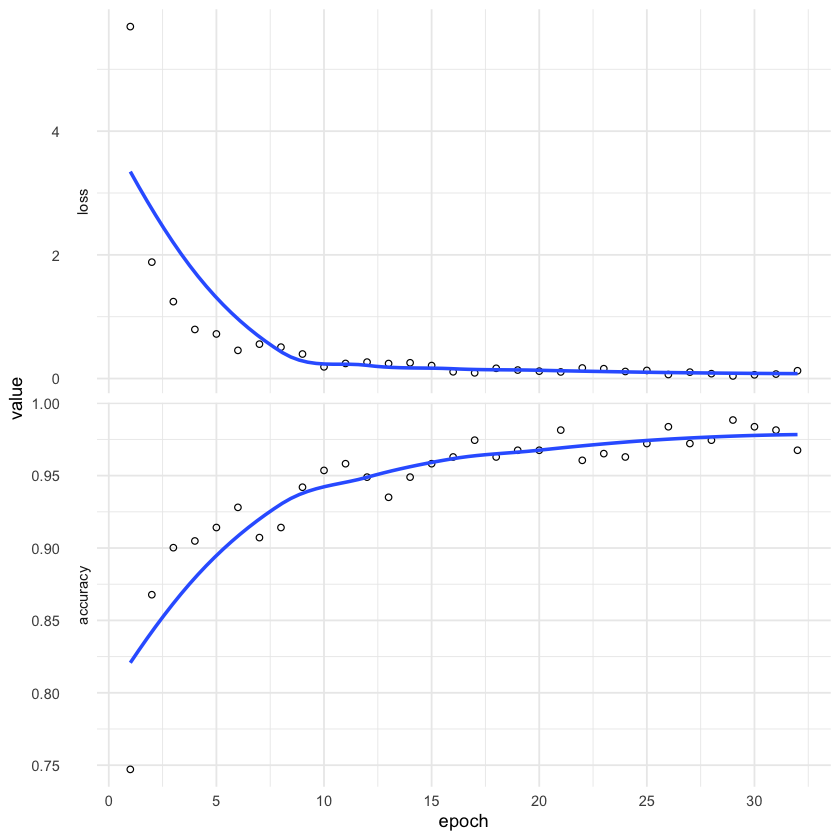

In [12]:
plot(model_HCV_fitted) + theme_minimal()

In [13]:
set.seed(0) 
score = model_HCV %>% evaluate(test_x, test_labels)

cat('Test loss:', score[1], "\n")
cat('Test accuracy:', score[2], "\n")


Test loss: 0.7457765 
Test accuracy: 0.9293478 


In [14]:
library(ramify)
library(yardstick)
predictions <- model_HCV %>% predict(test_x) 
classes=argmax(predictions) %>% as.vector()


Attaching package: ‘ramify’


The following object is masked from ‘package:purrr’:

    flatten


The following object is masked from ‘package:tidyr’:

    fill


The following object is masked from ‘package:graphics’:

    clip


For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.


Attaching package: ‘yardstick’


The following object is masked from ‘package:keras’:

    get_weights


The following object is masked from ‘package:readr’:

    spec




In [15]:
estimates_keras_tbl <- tibble(
  truth      = as.factor(test_labels),
  estimate   = as.factor(classes),
  class_prob = predictions)
estimates_keras_tbl$class_prob_new = apply(estimates_keras_tbl$class_prob,1, FUN=max)
estimates_keras_tbl$estimate <- as.character(estimates_keras_tbl$estimate)

estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "1"] <- "0"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "2"] <- "1"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "3"] <- "2"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "4"] <- "3"

estimates_keras_tbl$estimate <- as.factor(estimates_keras_tbl$estimate)

In [16]:
library(purrr)
library(tidyr)

In [17]:
cm=estimates_keras_tbl %>% conf_mat(truth, estimate)
# Now reshape these into a matrix
tidy_cm=tidy(cm)
cm_mat <- matrix(tidy_cm$value, byrow = TRUE, ncol = 4)
rownames(cm_mat) <- c(0,1,2,3)
colnames(cm_mat) <- c(0,1,2,3)
cm_mat

,0,1,2,3
0,160,2,0,0
1,0,7,0,0
2,1,4,1,0
3,0,5,1,3


In [18]:
estimates_keras_tbl %>% metrics (truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9293478
kap,multiclass,0.6856354


In [19]:
n = sum(cm_mat) # number of instances
nc = nrow(cm_mat) # number of classes
diag = diag(cm_mat) # number of correctly classified instances per class 
rowsums = apply(cm_mat, 1, sum) # number of instances per class
colsums = apply(cm_mat, 2, sum) # number of predictions per class
p = rowsums / n # distribution of instances over the actual classes
q = colsums / n # distribution of instances over the predicted classes

In [20]:
precision = diag / colsums 
recall = diag / rowsums 
f1 = 2 * precision * recall / (precision + recall) 
data.frame(precision, recall, f1) 

,precision,recall,f1
,<dbl>,<dbl>,<dbl>
0,0.9937888,0.9876543,0.9907121
1,0.3888889,1.0000000,0.5600000
2,0.5000000,0.1666667,0.2500000
3,1.0000000,0.3333333,0.5000000


## SMOTE-Results

In [145]:
train_x_smote=read.csv(file = '/Users/shreya/Downloads/X_Train_SMOTE.csv')
train_labels_smote = read.csv(file = '/Users/shreya/Downloads/y_train_SMOTE.csv')
train_x_smote=as.matrix(train_x_smote)
train_labels_smote=as.matrix(train_labels_smote)

In [146]:
set.seed(0) 
model_HCV_smote<- keras_model_sequential()
model_HCV_smote %>%
  layer_dense(units = 200, activation = 'relu') %>%
  layer_dense(units = 500, activation = 'relu') %>%
  layer_dropout(0.15) %>%
  layer_dense(units = 4, activation = 'softmax')

In [147]:
set.seed(0) 
model_HCV_smote %>% compile(
  optimizer = optimizer_sgd(lr=0.01), 
  loss = 'sparse_categorical_crossentropy',
  metrics = c('accuracy')
)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


In [148]:
set.seed(0) 
model_HCV_fitted_smote = model_HCV_smote %>% fit(train_x_smote, train_labels_smote, epochs = 32,
                                            batch_size=10  ) #   , batch_size=10, shuffle=FALSE)

In [149]:
set.seed(0) 
score = model_HCV_smote %>% evaluate(test_x, test_labels)

cat('Test loss:', score[1], "\n")
cat('Test accuracy:', score[2], "\n")

Test loss: 0.6769301 
Test accuracy: 0.9402174 


In [150]:
library(ramify)
library(yardstick)
predictions <- model_HCV_smote %>% predict(test_x) 
classes=argmax(predictions) %>% as.vector()

In [151]:
estimates_keras_tbl <- tibble(
  truth      = as.factor(test_labels),
  estimate   = as.factor(classes),
  class_prob = predictions)
estimates_keras_tbl$class_prob_new = apply(estimates_keras_tbl$class_prob,1, FUN=max)
estimates_keras_tbl$estimate <- as.character(estimates_keras_tbl$estimate)

estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "1"] <- "0"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "2"] <- "1"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "3"] <- "2"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "4"] <- "3"

estimates_keras_tbl$estimate <- as.factor(estimates_keras_tbl$estimate)

In [121]:
library(purrr)
library(tidyr)
cm=estimates_keras_tbl %>% conf_mat(truth, estimate)
# Now reshape these into a matrix
tidy_cm=tidy(cm)
cm_mat <- matrix(tidy_cm$value, byrow = TRUE, ncol = 4)
rownames(cm_mat) <- c(0,1,2,3)
colnames(cm_mat) <- c(0,1,2,3)
cm_mat

,0,1,2,3
0,158,2,1,1
1,0,5,2,0
2,1,1,3,1
3,1,1,3,4


In [152]:
library(purrr)
library(tidyr)
cm=estimates_keras_tbl %>% conf_mat(truth, estimate)
# Now reshape these into a matrix
tidy_cm=tidy(cm)
cm_mat <- matrix(tidy_cm$value, byrow = TRUE, ncol = 4)
rownames(cm_mat) <- c(0,1,2,3)
colnames(cm_mat) <- c(0,1,2,3)
cm_mat

,0,1,2,3
0,160,1,1,0
1,0,5,2,0
2,1,1,3,1
3,1,1,2,5


In [153]:
n = sum(cm_mat) # number of instances
nc = nrow(cm_mat) # number of classes
diag = diag(cm_mat) # number of correctly classified instances per class 
rowsums = apply(cm_mat, 1, sum) # number of instances per class
colsums = apply(cm_mat, 2, sum) # number of predictions per class
p = rowsums / n # distribution of instances over the actual classes
q = colsums / n # distribution of instances over the predicted classes

In [110]:
tn_0=(3+3+1+1+3+1+0+2+7)
fp_0=(1+2+2)

tn_1=157+2+2+1+2+1+0+2+7
fp_1=0+3+1

tn_2=157+1+2+0+3+1+0+0+7
fp_2=3

tn_3=157+1+2+0+3+3+1+1+3
fp_3=2

In [156]:
precision = diag / colsums 
recall = diag / rowsums 
f1 = 2 * precision * recall / (precision + recall) 
data.frame(precision, recall, f1) 

,precision,recall,f1
,<dbl>,<dbl>,<dbl>
0,0.9876543,0.9876543,0.9876543
1,0.6250000,0.7142857,0.6666667
2,0.3750000,0.5000000,0.4285714
3,0.8333333,0.5555556,0.6666667


In [155]:
#specificity per class
c(tn_0/(tn_0+fp_0), tn_1/(tn_1+fp_1), tn_2/(tn_2+fp_2), tn_3/(tn_3+fp_3))

[1] 0.8076923 0.9775281 0.9827586 0.9884393